# NBA Machine Learning

The objective for our project will be to create a deep learning model that will be able to predict future outcomes of a basketball season. 
This is done because this could be used as a viable tool in the process of sports betting. The model would function almost exactly the same as one that predicts stock price and signals when to buy or sell, the only difference is that it would predict a player's stat and would signal when to bet instead of buying/selling.

Our project will use historical data from NBA teams such as previous season's records, shot making percentages, defensive ratings, 
and several others from the last ten seasons in a deep learning model to predict the next season's standings for each season and individual player statistics.


In [1]:
#import libraries required to run program
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder

2023-06-07 21:35:30.863217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import csv containing Jokic's statistics
jokic_csv_path = Path("Resources/jokic_ultimate.csv")
jokic_df = pd.read_csv(jokic_csv_path)

In [3]:
#dropped columns that were not relevant to model
jokic_df.drop(columns= ["Rk","Tm","Date","Age","Opp"], axis=1, inplace = True)
jokic_df.head()
jokic_df.columns

Index(['G', 'Unnamed: 5', 'Unnamed: 7', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-', 'TS%', 'eFG%', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'BPM'],
      dtype='object')

In [4]:
#added titles to columns without names
jokic_df.rename(columns={'Unnamed: 5':'Home_or_Away'},inplace= True)
jokic_df.rename(columns={'Unnamed: 7':'MOV'},inplace= True)

In [5]:
#changed Home or Away column so that if the game was at home it is a value of 0 and if away it is 1
jokic_df['Home_or_Away'] = jokic_df['Home_or_Away'].replace('@', 1)
jokic_df = jokic_df.fillna(0)
jokic_df

,G,Home_or_Away,MOV,GS,MP,FG,FGA,FG%,3P,3PA,...,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM
0,1.0,1.0,L (-21),1,33:25,12.0,17.0,0.706,1.0,3.0,...,8.0,7.4,37.9,4.3,0.0,14.4,26.8,136.0,119.0,13.7
1,1.0,1.0,L (-21),1,33:25,12.0,17.0,0.706,1.0,3.0,...,31.6,25.6,32.7,1.8,0.0,7.0,22.5,124.0,83.0,6.4
2,1.0,0.0,W (+29),1,28:29,6.0,12.0,0.500,0.0,0.0,...,8.0,7.4,37.9,4.3,0.0,14.4,26.8,136.0,119.0,13.7
3,1.0,0.0,W (+29),1,28:29,6.0,12.0,0.500,0.0,0.0,...,31.6,25.6,32.7,1.8,0.0,7.0,22.5,124.0,83.0,6.4
4,2.0,1.0,W (+5),1,34:24,7.0,13.0,0.538,1.0,2.0,...,34.9,22.0,38.5,0.0,0.0,21.9,27.2,138.0,119.0,7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,77.0,0.0,W (+28),1,28:40,9.0,10.0,0.900,0.0,1.0,...,36.8,21.7,47.2,0.0,0.0,30.6,25.7,125.0,87.0,11.9
579,78.0,0.0,W (+9),1,36:45,9.0,15.0,0.600,1.0,4.0,...,33.5,21.5,37.6,2.8,2.3,10.7,23.2,139.0,111.0,12.8
580,0.0,1.0,L (-7),Inactive,0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581,79.0,1.0,L (-10),1,16:03,1.0,6.0,0.167,0.0,0.0,...,24.2,18.9,15.7,3.0,5.9,12.7,22.5,57.0,112.0,-15.1


In [6]:
#remove rows with games Jokic did not play
jokic_df = jokic_df[jokic_df['GS'] != "Inactive"]
jokic_df = jokic_df[jokic_df['GS'] != "Did Not Dress"]
jokic_df = jokic_df[jokic_df['GS'] != "Did Not Play"]
display(jokic_df)

,G,Home_or_Away,MOV,GS,MP,FG,FGA,FG%,3P,3PA,...,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM
0,1.0,1.0,L (-21),1,33:25,12.0,17.0,0.706,1.0,3.0,...,8.0,7.4,37.9,4.3,0.0,14.4,26.8,136.0,119.0,13.7
1,1.0,1.0,L (-21),1,33:25,12.0,17.0,0.706,1.0,3.0,...,31.6,25.6,32.7,1.8,0.0,7.0,22.5,124.0,83.0,6.4
2,1.0,0.0,W (+29),1,28:29,6.0,12.0,0.500,0.0,0.0,...,8.0,7.4,37.9,4.3,0.0,14.4,26.8,136.0,119.0,13.7
3,1.0,0.0,W (+29),1,28:29,6.0,12.0,0.500,0.0,0.0,...,31.6,25.6,32.7,1.8,0.0,7.0,22.5,124.0,83.0,6.4
4,2.0,1.0,W (+5),1,34:24,7.0,13.0,0.538,1.0,2.0,...,34.9,22.0,38.5,0.0,0.0,21.9,27.2,138.0,119.0,7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,76.0,1.0,L (-14),1,27:42,4.0,10.0,0.400,0.0,3.0,...,12.7,9.1,35.8,6.5,0.0,34.6,24.3,73.0,104.0,-1.5
578,77.0,0.0,W (+28),1,28:40,9.0,10.0,0.900,0.0,1.0,...,36.8,21.7,47.2,0.0,0.0,30.6,25.7,125.0,87.0,11.9
579,78.0,0.0,W (+9),1,36:45,9.0,15.0,0.600,1.0,4.0,...,33.5,21.5,37.6,2.8,2.3,10.7,23.2,139.0,111.0,12.8
581,79.0,1.0,L (-10),1,16:03,1.0,6.0,0.167,0.0,0.0,...,24.2,18.9,15.7,3.0,5.9,12.7,22.5,57.0,112.0,-15.1


In [7]:
#convert minutes played column to seconds played 
def convert_to_numerical(time_obj):
    minutes, seconds = time_obj.split(':')
    total_seconds = int(minutes) * 60 + int(seconds)
    return total_seconds

jokic_df['MP'] = jokic_df['MP'].apply(convert_to_numerical)
jokic_df.rename(columns={'MP':'Seconds_played'},inplace =True)

In [8]:
#converted columns with float64 types to int64 types
jokic_int_df = jokic_df[['G', 'Home_or_Away','FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-', 'TS%', 'eFG%', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg',
       'BPM']].round().astype('int64')


In [9]:
#concat dataframes that contained all columns
jokic_df.drop(columns= ['G', 'Home_or_Away','FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-', 'TS%', 'eFG%', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg',
       'BPM'], axis=1, inplace = True)
jokic_full_df = pd.concat([jokic_df, jokic_int_df], axis=1)

In [10]:
#changed MOV to win or loss column and another with actual margin
jokic_full_df['WinOrLoss'] = jokic_full_df['MOV'].str[0].map({'L':0,'W':1})
jokic_full_df['Margin'] = jokic_full_df['MOV'].str[1:].str.extract("(\d+)").astype(int)

In [11]:
#dropped MOV, G and GS
jokic_full_df.drop(columns= ["MOV","GS","G"], axis=1, inplace = True)

In [12]:
display(jokic_full_df)

,Seconds_played,Home_or_Away,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM,WinOrLoss,Margin
0,2005,1,12,17,1,1,3,0,2,2,...,38,4,0,14,27,136,119,14,0,21
1,2005,1,12,17,1,1,3,0,2,2,...,33,2,0,7,22,124,83,6,0,21
2,1709,0,6,12,0,0,0,0,1,3,...,38,4,0,14,27,136,119,14,1,29
3,1709,0,6,12,0,0,0,0,1,3,...,33,2,0,7,22,124,83,6,1,29
4,2064,1,7,13,1,1,2,0,11,11,...,38,0,0,22,27,138,119,7,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,1662,1,4,10,0,0,3,0,2,3,...,36,6,0,35,24,73,104,-2,0,14
578,1720,0,9,10,1,0,1,0,2,3,...,47,0,0,31,26,125,87,12,1,28
579,2205,0,9,15,1,1,4,0,3,4,...,38,3,2,11,23,139,111,13,1,9
581,963,1,1,6,0,0,0,0,0,2,...,16,3,6,13,22,57,112,-15,0,10


In [13]:
#set target for model
y = jokic_full_df['PTS'].values
display(y)

array([27, 27, 13, 13, 26, 26, 27, 27, 19, 19, 20, 20,  9,  9, 43, 43, 31,
       31, 28, 28, 12, 12, 24, 24, 23, 23, 39, 39, 15, 15, 30, 30, 21, 21,
       53, 53, 26, 26, 29, 29, 24, 24, 32, 32, 29, 29, 34, 34,  8,  8, 23,
       23, 24, 24, 30, 30, 27, 27, 31, 39, 19, 32, 17, 24, 32, 19, 33, 31,
       43, 25, 40, 13, 29, 41, 20, 40, 19, 30, 24, 12, 28, 14, 21, 17, 36,
       31, 25, 24, 26, 22, 14, 20, 29, 30, 27, 14, 24, 15, 40, 14, 18, 17,
       18, 37, 35, 28, 30, 24, 22, 31, 31, 25, 14,  6, 27, 27, 25, 25, 32,
       32, 26, 26, 24, 24, 37, 37, 24, 24, 37, 37, 11, 11, 30, 30, 26, 23,
       34, 28, 25, 22, 28, 35, 30, 24, 18, 32, 17, 39, 22, 35, 28, 27, 20,
       13, 29, 26, 22, 24, 27, 26, 33, 22, 21, 20, 17, 25, 49, 26, 34, 28,
       26, 29, 18, 21, 25, 27, 21, 23, 28, 26, 35, 25, 18,  8, 22, 46, 32,
       38, 23, 26, 22, 29, 32, 23, 30, 28, 35, 26, 37, 38, 38, 41, 35, 29,
       29, 34, 34, 24, 24, 38, 38, 19, 19, 36, 36, 26, 26, 16, 16, 17, 17,
       38, 38, 19, 19, 36

In [14]:
#set features for model
X = jokic_full_df.drop(columns= ['PTS', 'Home_or_Away','TRB','PF', 'GmSc', '+/-', 'eFG%', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORB', 'DRB', 
       'WinOrLoss', 'Margin']).values
display(X)

array([[2005,   12,   17, ...,  136,  119,   14],
       [2005,   12,   17, ...,  124,   83,    6],
       [1709,    6,   12, ...,  136,  119,   14],
       ...,
       [2205,    9,   15, ...,  139,  111,   13],
       [ 963,    1,    6, ...,   57,  112,  -15],
       [2195,   13,   26, ...,  100,   93,    4]])

In [15]:
#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [16]:
#scale data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [17]:
#create variables for layers
number_input_features = 18
number_output_neurons = 1
hidden_nodes_layer1 = 16
hidden_nodes_layer2 = 8
hidden_nodes_layer3 = 4

In [18]:
#create instance of model
nn = Sequential()

In [19]:
#add layers
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))
nn.add(Dense(units=hidden_nodes_layer3, activation="relu"))
nn.add(Dense(units=1, activation="linear"))

In [20]:
#view summary of model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                304       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [21]:
#compile model
nn.compile(loss= "mse", optimizer="adam", metrics=["mse"])

In [22]:
#fit model
jokic_deep_model = nn.fit(X_train_scaled, y_train, epochs=500)

Epoch 1/500
14/14 [==============================] - 1s 3ms/step - loss: 658.6687 - mse: 658.6687
Epoch 2/500
14/14 [==============================] - 0s 3ms/step - loss: 655.8519 - mse: 655.8519
Epoch 3/500
14/14 [==============================] - 0s 2ms/step - loss: 654.3211 - mse: 654.3211
Epoch 4/500
14/14 [==============================] - 0s 2ms/step - loss: 653.2432 - mse: 653.2432
Epoch 5/500
14/14 [==============================] - 0s 2ms/step - loss: 652.3300 - mse: 652.3300
Epoch 6/500
14/14 [==============================] - 0s 2ms/step - loss: 651.4852 - mse: 651.4852
Epoch 7/500
14/14 [==============================] - 0s 2ms/step - loss: 650.6425 - mse: 650.6425
Epoch 8/500
14/14 [==============================] - 0s 2ms/step - loss: 649.7167 - mse: 649.7167
Epoch 9/500
14/14 [==============================] - 0s 2ms/step - loss: 648.4583 - mse: 648.4583
Epoch 10/500
14/14 [==============================] - 0s 2ms/step - loss: 646.5297 - mse: 646.5297
Epoch 11/500
14/14 

In [23]:
#evaluate model's loss and MSE 
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

5/5 - 0s - loss: 1.3974 - mse: 1.3974 - 335ms/epoch - 67ms/step


<AxesSubplot:>

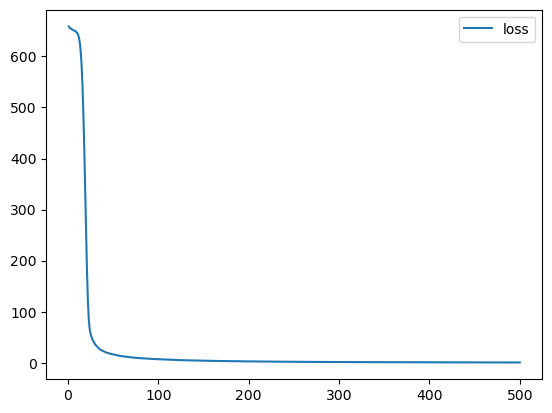

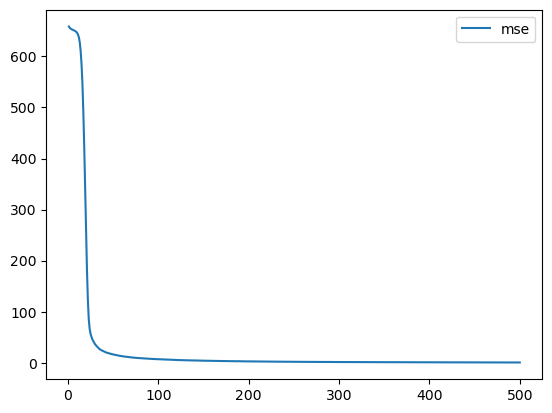

In [24]:
# plot the loss and mse of the Points prediction model
points_history_df = pd.DataFrame(jokic_deep_model.history, index=range(1, len(jokic_deep_model.history["loss"]) + 1))
points_history_df.plot(y="loss")
points_history_df.plot(y="mse")

In [25]:
#compare predictions to actual results 
predictions = (nn.predict(X_test_scaled)).astype("int32")
results = pd.DataFrame({"predictions": predictions.ravel(), "actual":y_test})
display(results)

5/5 [==============================] - 0s 2ms/step


,predictions,actual
0,25,29
1,13,14
2,38,38
3,28,33
4,43,41
...,...,...
135,17,18
136,34,36
137,18,18
138,19,20


In [26]:
#save model
# nn.save('jokic_deep_model.h5')

In [27]:
#Alternate Model for predicting Assists
y2 = jokic_full_df['AST'].values
X2 = jokic_full_df.drop(columns= ['AST', 'Home_or_Away','TRB','PF', 'GmSc', '+/-', 'eFG%', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORB', 'DRB', 
       'WinOrLoss', 'Margin']).values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=1)
scaler = StandardScaler()
X_scaler2 = scaler.fit(X_train2)
X_train_scaled2 = X_scaler2.transform(X_train2)
X_test_scaled2 = X_scaler2.transform(X_test2)
nn2 = Sequential()
nn2.add(Dense(units=hidden_nodes_layer1, input_dim= 18, activation="relu"))
nn2.add(Dense(units=hidden_nodes_layer2, activation="relu"))
nn2.add(Dense(units=hidden_nodes_layer3, activation="relu"))
nn2.add(Dense(units=2, activation="relu"))
nn2.add(Dense(units=1, activation="linear"))
nn2.compile(loss= "mse", optimizer="adam", metrics=["mse"])
jokic_deep_model_assist = nn2.fit(X_train_scaled2, y_train2, epochs=1000)

Epoch 1/1000
14/14 [==============================] - 1s 2ms/step - loss: 72.5581 - mse: 72.5581
Epoch 2/1000
14/14 [==============================] - 0s 2ms/step - loss: 72.2489 - mse: 72.2489
Epoch 3/1000
14/14 [==============================] - 0s 2ms/step - loss: 72.0002 - mse: 72.0002
Epoch 4/1000
14/14 [==============================] - 0s 4ms/step - loss: 71.7760 - mse: 71.7760
Epoch 5/1000
14/14 [==============================] - 0s 2ms/step - loss: 71.5489 - mse: 71.5489
Epoch 6/1000
14/14 [==============================] - 0s 3ms/step - loss: 71.3309 - mse: 71.3309
Epoch 7/1000
14/14 [==============================] - 0s 2ms/step - loss: 71.1139 - mse: 71.1139
Epoch 8/1000
14/14 [==============================] - 0s 2ms/step - loss: 70.8991 - mse: 70.8991
Epoch 9/1000
14/14 [==============================] - 0s 2ms/step - loss: 70.6882 - mse: 70.6882
Epoch 10/1000
14/14 [==============================] - 0s 3ms/step - loss: 70.4811 - mse: 70.4811
Epoch 11/1000
14/14 [========

In [28]:
#conmpare predictions to actual results for assists model
predictions2 = (nn2.predict(X_test_scaled2)).astype("int32")
model_loss2, model_accuracy2 = nn2.evaluate(X_test_scaled2, y_test2, verbose=2)
results2 = pd.DataFrame({"Predictions": predictions2.ravel(), "actual":y_test2})
display(results2)

5/5 [==============================] - 0s 2ms/step
5/5 - 0s - loss: 11.8711 - mse: 11.8711 - 191ms/epoch - 38ms/step


,Predictions,actual
0,7,10
1,7,7
2,7,9
3,7,7
4,7,4
...,...,...
135,7,8
136,7,5
137,7,15
138,7,6


<AxesSubplot:>

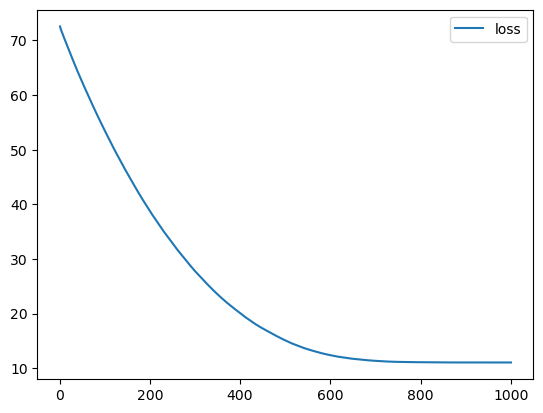

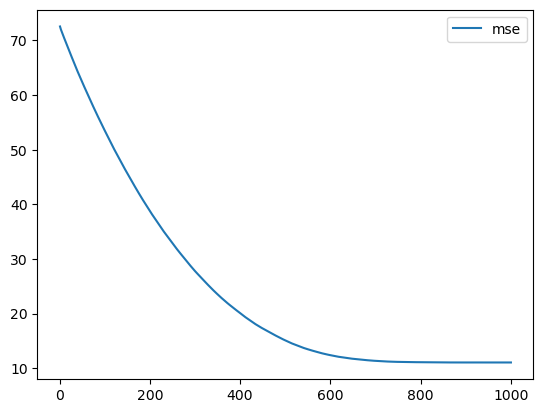

In [29]:
# plot the loss and mse of the assists prediction model
assists_history_df = pd.DataFrame(jokic_deep_model_assist.history, index=range(1, len(jokic_deep_model_assist.history["loss"]) + 1))
assists_history_df.plot(y="loss")
assists_history_df.plot(y="mse")

In [30]:
# import average stats of Jokic against each nba team to use in predicting next game's points Jokic will score
opposing_team_df = pd.read_csv('Resources/final_opponents.csv')
opposing_team_df['Seconds_played'] = opposing_team_df['MP'] * 60
opposing_team_df.set_index('Team', inplace=True)
opposing_team_df = opposing_team_df[['MP', 'FG%', '3P%', 'FT%', 'TS%', 'USG%','PTS', 'TRB',
       'AST', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'TRB.1', 'STL', 'BLK',
       'TOV', 'BPM', 'Seconds_played']].round().astype('int64')
opposing_team_df.drop(columns= ["MP","TRB.1"], axis=1, inplace = True)
display(opposing_team_df)

,FG%,3P%,FT%,TS%,USG%,PTS,TRB,AST,FG,FGA,3P,3PA,FT,FTA,STL,BLK,TOV,BPM,Seconds_played
Team,,,,,,,,,,,,,,,,,,,
Atlanta,0,0,1,1,26,18,11,6,7,14,1,4,3,4,2,1,2,4,1806
Boston,1,0,1,1,28,22,10,6,8,15,1,4,4,4,1,1,3,1,1848
Charlotte,1,0,1,1,29,22,14,7,8,16,1,3,4,6,1,1,3,8,1926
Chicago,1,0,1,1,27,18,10,8,7,14,1,3,2,3,1,1,2,9,1680
Cleveland,1,0,1,1,24,18,11,7,7,12,1,2,3,4,1,0,3,4,1872
Dallas,1,0,1,1,27,18,11,6,7,14,1,3,3,4,1,0,3,3,1800
Detroit,1,0,1,1,27,21,9,6,8,15,1,2,4,5,2,1,2,5,1830
Golden State,0,0,1,1,27,18,10,7,7,13,0,2,4,5,2,0,4,-2,1776
Houston,1,0,1,1,29,19,10,6,8,13,0,2,3,4,1,1,4,2,1656


In [31]:
# create dataframe with only Eastern Conference Teams
eastern_df = opposing_team_df.loc[['Washington', 'Atlanta', 'Milwaukee', 'Boston', 'Philadelphia', 'Cleveland', 'New York', 'New Jersey', 'Miami', 'Toronto', 'Chicago', 'Indiana', 'Orlando', 'Charlotte', 'Detroit']].copy()
eastern_df

,FG%,3P%,FT%,TS%,USG%,PTS,TRB,AST,FG,FGA,3P,3PA,FT,FTA,STL,BLK,TOV,BPM,Seconds_played
Team,,,,,,,,,,,,,,,,,,,
Washington,1,1,1,1,27,22,11,6,8,14,1,2,4,5,1,1,3,6,1842
Atlanta,0,0,1,1,26,18,11,6,7,14,1,4,3,4,2,1,2,4,1806
Milwaukee,1,0,1,1,27,21,10,8,8,16,2,4,3,3,1,1,3,4,1884
Boston,1,0,1,1,28,22,10,6,8,15,1,4,4,4,1,1,3,1,1848
Philadelphia,1,0,1,1,27,22,10,8,8,15,1,3,6,7,1,1,3,6,1980
Cleveland,1,0,1,1,24,18,11,7,7,12,1,2,3,4,1,0,3,4,1872
New York,1,0,1,1,29,22,10,6,9,15,1,3,4,4,1,1,2,8,1806
New Jersey,1,0,1,1,27,23,12,6,9,15,1,3,4,5,1,1,2,6,1818
Miami,1,0,1,1,25,20,11,6,8,14,1,3,3,4,1,1,2,8,1956


In [32]:
# Process and Scale input for Eastern Conference
EX = eastern_df.drop(columns= 'PTS').values
Ey = eastern_df['PTS'].values
EX_train, EX_test, Ey_train, Ey_test = train_test_split(EX, Ey, random_state=1)
EX_scaler = scaler.fit(EX_train)
EX_train_scaled = scaler.transform(EX_train)
EX_test_scaled = EX_scaler.transform(EX_test)

In [33]:
#predict points for future game with eastern conference team
east_future_game = (nn.predict(EX_test_scaled)).astype("int32")
results_east_future_game = pd.DataFrame({"Eastern Team Points": east_future_game.ravel()})
results_east_future_game

1/1 [==============================] - 0s 30ms/step


,Eastern Team Points
0,21
1,24
2,25
3,31


In [34]:
#save results of East future game points to CSV
# results_east_future_game.to_csv('eastern_game_predict.csv', index =False)

In [35]:
#predict assists for future game with eastern conference team
east_future_game_assist = (nn2.predict(EX_test_scaled)).astype("int32")
results_east_future_game_assist = pd.DataFrame({"Eastern Team Assists": east_future_game_assist.ravel()})
results_east_future_game_assist

1/1 [==============================] - 0s 26ms/step


,Eastern Team Assists
0,7
1,7
2,7
3,7


In [36]:
#save results of East future assists to CSV
# results_east_future_game_assist.to_csv('assist_eastern_game_predict.csv', index =False)

In [37]:
# create dataframe with only Western Conference Teams
western_df = opposing_team_df.loc[['Memphis', 'Sacramento', 'Phoenix', 'LA Clippers', 'Golden State', 'LA Lakers', 'Minnesota', 'New Orleans', 'Oklahoma City', 'Dallas', 'Utah', 'Portland', 'Houston', 'San Antonio']].copy()
western_df

,FG%,3P%,FT%,TS%,USG%,PTS,TRB,AST,FG,FGA,3P,3PA,FT,FTA,STL,BLK,TOV,BPM,Seconds_played
Team,,,,,,,,,,,,,,,,,,,
Memphis,1,0,1,1,25,20,10,6,7,13,1,3,4,4,1,0,3,6,1902
Sacramento,1,0,1,1,25,19,11,7,7,13,1,3,4,4,1,1,3,5,1872
Phoenix,1,0,1,1,26,20,11,6,8,13,1,2,5,5,1,1,3,9,1902
LA Clippers,1,0,1,1,27,21,11,6,8,14,1,3,5,6,1,1,3,3,1830
Golden State,0,0,1,1,27,18,10,7,7,13,0,2,4,5,2,0,4,-2,1776
LA Lakers,1,0,1,1,26,19,10,6,7,13,1,3,4,5,1,1,3,6,1830
Minnesota,1,0,1,1,28,20,11,7,8,15,1,3,4,4,1,1,3,6,1920
New Orleans,1,0,1,1,28,22,10,7,8,14,1,3,3,4,1,1,3,4,1800
Oklahoma City,1,0,1,1,26,21,11,7,8,14,1,3,4,5,1,1,3,6,1908


In [38]:
# Process and Scale input for Eastern Conference
WX = western_df.drop(columns= 'PTS').values
Wy = western_df['PTS'].values
WX_train, WX_test, Wy_train, Wy_test = train_test_split(WX, Wy, random_state=1)
WX_scaler = scaler.fit(WX_train)
WX_train_scaled = scaler.transform(WX_train)
WX_test_scaled = WX_scaler.transform(WX_test)

In [39]:
#predict points for future game with eastern conference team
west_future_game = (nn.predict(WX_test_scaled)).astype("int32")
west_results_future_game = pd.DataFrame({"Western Team Points": west_future_game.ravel()})
west_results_future_game

1/1 [==============================] - 0s 31ms/step


,Western Team Points
0,25
1,24
2,24
3,24


In [40]:
#save results of West future game points to CSV
# west_results_future_game.to_csv('western_game_predict.csv', index =False)

In [41]:
#predict assists for future game with western conference team
west_future_game_assist = (nn2.predict(WX_test_scaled)).astype("int32")
results_west_future_game_assist = pd.DataFrame({"Western Team Assists": west_future_game_assist.ravel()})
results_west_future_game_assist

1/1 [==============================] - 0s 30ms/step


,Western Team Assists
0,7
1,7
2,7
3,7


In [42]:
#save results of West future assists to CSV
# results_west_future_game_assist.to_csv('assist_western_game_predict.csv', index =False)